In [87]:
import pandas as pd
import os
import torch
from transformers import Trainer, BertTokenizer
import numpy as np


os.chdir("/Users/lucasvilsen/Desktop/GrammatikTAK/")

test_sentences_verbs = pd.read_csv("Datasets/nutids-r-reviewed.csv", sep="|")
no_guess_df = pd.read_csv("Datasets/no_guess_df.csv", sep=";")
no_guess_lst = list(no_guess_df["comment_text"].values)

In [88]:
correct_sentences = test_sentences_verbs["correct"].values
correct_sentences[:2]

array(['Det er ikke altid nemt at forsvare din opførsel',
       'Mange drenge interesserer sig for fodbold'], dtype=object)

In [89]:
os.chdir("/Users/lucasvilsen/Desktop/GrammatikTAK/Datasets/")
filename = "europarl-v7.da-en.da"
with open(filename, "r", encoding="UTF-8") as file:
    lines = file.readlines()

In [90]:
correct_sentences = lines[300000:305000]
correct_sentences = [line.strip("\n") for line in correct_sentences]
correct_sentences[:2]

['Livscyklussen, miljøbelastningen ved fremstilling af biobrændstoffer bliver nævnt.',
 'Hvem udregner livscyklussen for traditionelle brændstoffer?']

In [91]:
os.chdir("/Users/lucasvilsen/Desktop/GrammatikTAK/")

import pickle
import stanza
from tqdm import tqdm

def get_pos(x):
    with open("FineTuneModels/pos_caching.pkl", "rb") as f:
        pos_list = pickle.load(f)
    if len(pos_list) != len(x):
        pos_list = []
        pos_tagger = stanza.Pipeline("da", processors='tokenize,pos', use_gpu=True, cache_directory='./cache', tokenize_pretokenized=True, n_process=4)
        for sentence in tqdm(x):
            pos = get_pos_tags(sentence, pos_tagger)
            pos_list.append(pos)
        print(len(pos_list))
        print("Updating")
        with open("FineTuneModels/pos_caching.pkl", "wb") as f:
            pickle.dump(pos_list, f)
        print("Updated")
    else:
        print("pos_caching.pkl already exists")
    return pos_list

def get_pos_tags(sentence, pos_tagger):
    doc = pos_tagger(sentence)
    features = [word.feats if word.feats else None for sentence in doc.sentences for word in sentence.words]
    feature_dicts = turn_features_to_dicts(features)
    results = [(word.upos, [word.start_char, word.end_char], feature_dicts[i]) for sentence in doc.sentences for i, word in enumerate(sentence.words)]
    return results

def turn_features_to_dicts(features):
    feature_dicts = []
    current_tense = None
    for feature in features:
        if feature is None:
            feature_dicts.append({})
            continue
        feature_dict = {}
        current_features = feature.split("|")
        for current_feature in current_features:
            key, value = current_feature.split("=")
            if key == "Tense" and current_tense is None:
                current_tense = value
            feature_dict[key] = value
        if "Tense" not in feature_dict and "VerbForm" in feature_dict and key is not None:
            feature_dict["Tense"] = "Pres" if current_tense is None else current_tense
        feature_dicts.append(feature_dict)
    return feature_dicts

all_pos = get_pos(correct_sentences)

pos_caching.pkl already exists


In [92]:
os.chdir("/Users/lucasvilsen/Desktop/GrammatikTAK/Datasets/")
filename = "europarl-v7.da-en.da"
with open(filename, "r", encoding="UTF-8") as file:
    lines = file.readlines()
with open("nutids_r_bøjninger.pickle", "rb") as f:
    nutids_r_bøjninger = pickle.load(f)
with open("nutids_r_stem.pickle", "rb") as f:
    nutids_r_stem = pickle.load(f)

In [101]:
from tqdm import tqdm

testset = []
labels = []

padded_words = []

padding_left = 10
padding_right = 4

def get_pos_tags(index):
    current_pos = all_pos[index]
    return [current_pos[i][0] for i in range(len(current_pos))]

og_index = 0
no_guess_lst_index = 0
comma_right_before_index = 0

for i in tqdm(range(len(correct_sentences))):
    line = correct_sentences[i]
    if len(str(line)) < 1 or str(line) == "nan":
        continue
    line = line.strip("\n")
    true_words = line.split()
    pos = get_pos_tags(i)
    words = ["<PAD>"]*padding_left + pos + ["<PAD>"]*padding_right
    true_padded_words = ["<PAD>"]*padding_left + true_words + ["<PAD>"]*padding_right
    for i, word in enumerate(true_words):
        try: stemmed = nutids_r_stem[word]
        except: continue
        if word[-1] == "s" or words[i+padding_left] != "VERB":
            continue
        if true_words[i-1].lower().strip() == "og": 
            og_index += 1
            continue
        if words in no_guess_lst:
            no_guess_lst_index += 1
            continue
        if true_words[i-1][-1] == ",":
            comma_right_before_index += 1
            continue
        if nutids_r_bøjninger[stemmed][0] == word:
            labels.append(1)
        else:
            labels.append(0)
        testset.append(" ".join(words[i:i+padding_left+padding_right+1]))
        padded_words.append(" ".join(true_padded_words[i:i+padding_left+padding_right+1]))

100%|██████████| 5000/5000 [00:49<00:00, 101.21it/s]


In [102]:
og_index, no_guess_lst_index, comma_right_before_index

(250, 0, 220)

In [103]:
df = pd.DataFrame(zip(testset, labels), columns=["comment_text", "label"])
print("Test size: ", len(df))
print("Label distribution: ")
df["label"].value_counts()

Test size:  6650
Label distribution: 


1    3676
0    2974
Name: label, dtype: int64

In [104]:
os.chdir("/Users/lucasvilsen/Desktop/GrammatikTAK/")
model_path = "FineTuneModels/models/nutidsrModel7-BERT"
model_name = "Model 7-BERT"

class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

def load_model(path):
    device = "mps"
    torch.device(device)
    classifier = torch.load(path, map_location=torch.device('cpu'))
    classifier.eval()
    classifier.to(device)
    return Trainer(classifier)


model = load_model(model_path)
tokenizer = BertTokenizer.from_pretrained('Maltehb/danish-bert-botxo')

def convert_dataset_to_dataloader(dataset):
    test_dataset = Dataset(dataset)
    return test_dataset

def tokenize_sentences(sentences):
    X_tokenized = tokenizer(sentences, padding=True, truncation=True)
    return X_tokenized

def get_predictions(dataloader):
    raw_predictions, _, _ = model.predict(dataloader)
    scores = torch.softmax(torch.from_numpy(raw_predictions), dim=1)
    max_scores, final_prediction = torch.max(scores, dim=1)
    final_prediction = np.argmax(raw_predictions, axis=1)
    return [(p, s) for p, s in zip(final_prediction, max_scores)]


def verbs_to_check(words, pos):
    pos = pos
    verbs = []
    for i in range(len(pos)):
        if pos[i][0] != "VERB":
            verbs.append(False)
        elif "Tense" not in pos[i][2].keys():
            verbs.append(False)
        elif pos[i][2]["Tense"] != "Pres":
            verbs.append(False)
        else:
            verbs.append(True)
    for i, bool in enumerate(verbs):
        if not bool:
            continue
        word = words[i].strip(",.!?():;")
        try: stemmed_verb = nutids_r_stem[word]
        except: verbs[i] = False; continue
    return verbs

tokenized = tokenize_sentences(testset)
dataloader = convert_dataset_to_dataloader(tokenized)
predictions = get_predictions(dataloader)

  0%|          | 0/832 [00:00<?, ?it/s]

In [106]:
true_predictions = [p for (p, s) in predictions]
true_score = [s for (p, s) in predictions]

import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(labels, true_predictions)
precision = precision_score(labels, true_predictions)
recall = recall_score(labels, true_predictions)
f1 = f1_score(labels, true_predictions)

data = {
    'Evaluation Measure': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Value': [accuracy, precision, recall, f1]
}
df = pd.DataFrame(data)

print(df)

  Evaluation Measure     Value
0           Accuracy  0.985113
1          Precision  0.989062
2             Recall  0.983950
3           F1 Score  0.986499


Accuracy before disqualifying "og: 97.8%

Accuracy after disqualifying "og" and before "," lst: 98.2%

Accuracy final: 98.5%

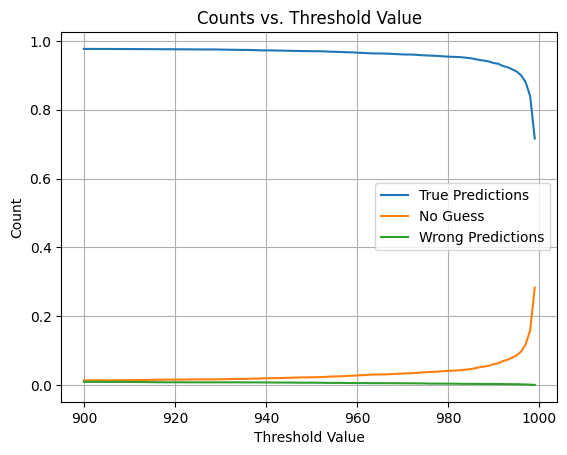

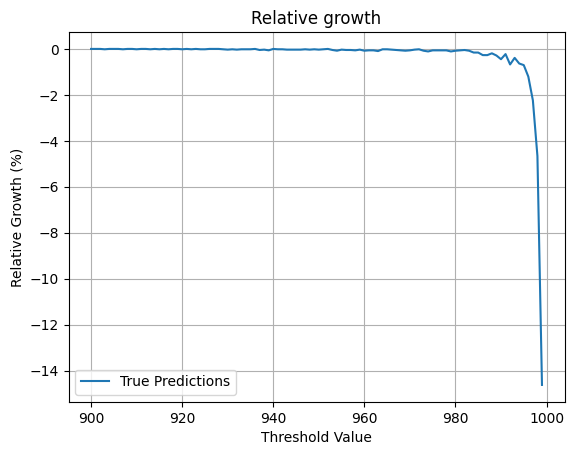

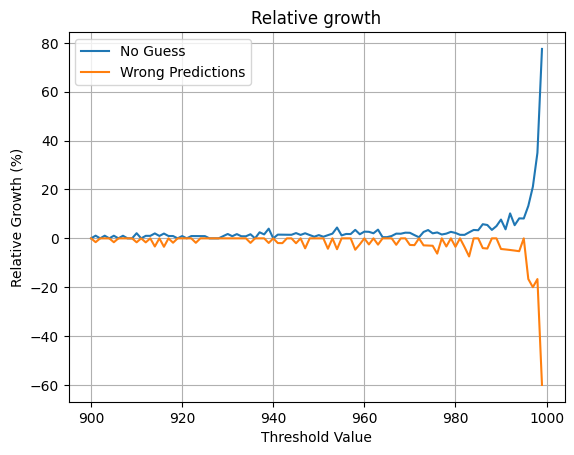

In [107]:
import matplotlib.pyplot as plt

def calculate_growth(previous, current):
    if previous == 0:
        return 0
    return (current - previous) / previous * 100

def test_cutoff(value):
    new_predictions = [p if s > value else None for (p, s) in predictions]
    true = sum([1 if p == t else 0 for (p, t) in zip(new_predictions, labels)])
    no_guess = sum([1 if p is None else 0 for p in new_predictions])
    wrong = sum([1 if p != t and p is not None else 0 for (p, t) in zip(new_predictions, labels)])
    return true/len(labels), no_guess/len(labels), wrong/len(labels)

def test_all_values():
    values = range(900, 1000)
    trues, no_guesss, wrongs = [], [], []
    for value in values:
        true, no_guess, wrong = test_cutoff(value/1000)
        trues.append(true)
        no_guesss.append(no_guess)
        wrongs.append(wrong)

    plt.plot(values, trues, label='True Predictions')
    plt.plot(values, no_guesss, label='No Guess')
    plt.plot(values, wrongs, label='Wrong Predictions')

    plt.xlabel('Threshold Value')
    plt.ylabel('Count')
    plt.title('Counts vs. Threshold Value')
    plt.legend()
    plt.grid(True)
    plt.show()

    previous_true = 0
    previous_no_guess = 0
    previous_wrong = 0

    trues, no_guesss, wrongs = [], [], []

    for value in values:
        true, no_guess, wrong = test_cutoff(value/1000)
        true_growth = calculate_growth(previous_true, true)
        no_guess_growth = calculate_growth(previous_no_guess, no_guess)
        wrong_growth = calculate_growth(previous_wrong, wrong)

        trues.append(true_growth)
        no_guesss.append(no_guess_growth)
        wrongs.append(wrong_growth)

        previous_true = true
        previous_no_guess = no_guess
        previous_wrong = wrong

    plt.plot(values, trues, label='True Predictions')
    plt.xlabel('Threshold Value')
    plt.ylabel('Relative Growth (%)')
    plt.title('Relative growth')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.plot(values, no_guesss, label='No Guess')
    plt.plot(values, wrongs, label='Wrong Predictions')

    plt.xlabel('Threshold Value')
    plt.ylabel('Relative Growth (%)')
    plt.title('Relative growth')
    plt.legend()
    plt.grid(True)
    plt.show()

test_all_values()
    


In [108]:
from tabulate import tabulate

table_data = [
    ("0.50", test_cutoff(0.50)),
    ("0.70", test_cutoff(0.70)),
    ("0.80", test_cutoff(0.80)),
    ("0.90", test_cutoff(0.90)),
    ("0.95", test_cutoff(0.95)),
    ("0.98", test_cutoff(0.98)),
    ("0.99", test_cutoff(0.99))
]

for i in range(len(table_data)):
    _1 = round(table_data[i][1][0]*100, 2)
    _2 = round(table_data[i][1][1]*100, 2)
    _3 = round(table_data[i][1][2]*100, 2)
    table_data[i] = (table_data[i][0], (_1, _2, _3))

# Find the highest accuracy, lowest wrong, and lowest no-guess percentages
highest_accuracy = max(table_data, key=lambda x: x[1][0])
lowest_wrong = min(table_data, key=lambda x: x[1][2])
lowest_no_guess = min(table_data, key=lambda x: x[1][1])

# Create the table
table = []
headers = ["Cutoff", "Correct (%)", "No Guess (%)", "Wrong (%)"]

for data in table_data:
    row = [data[0]] + list(data[1])
    table.append(row)

table_str = tabulate(table, headers, tablefmt="pipe")

# Print the table
print(table_str)

|   Cutoff |   Correct (%) |   No Guess (%) |   Wrong (%) |
|---------:|--------------:|---------------:|------------:|
|     0.5  |         98.51 |           0    |        1.49 |
|     0.7  |         98.39 |           0.21 |        1.4  |
|     0.8  |         98.21 |           0.53 |        1.26 |
|     0.9  |         97.67 |           1.37 |        0.96 |
|     0.95 |         97.01 |           2.29 |        0.71 |
|     0.98 |         95.43 |           4.15 |        0.42 |
|     0.99 |         93.56 |           6.11 |        0.33 |


## Error display:

In [109]:
errors_index = [True if p != t else False for (p, t) in zip(true_predictions, labels)]
errors = [padded_words[i] for i in range(len(padded_words)) if errors_index[i]]
print(*errors, sep="\n\n")

vi kan i det mindste i et vist omfang selv betjene og sikre vores brændstofmarked

<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> Jeg så gerne, at kontoret for

<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> Jeg så gerne, at den skabelon

min appel til Rådet, som har slået på subsidiariteten - løse dem gennem tilsvarende initiativer

der udsletter grænserne, efterlader os uden dem, og praktisk talt udsletter biografsalene. <PAD> <PAD> <PAD>

sektorer, som jeg lige har nævnt, ikke på nuværende tidspunkt acceptere forslaget om at udvide

at det er fint at indgå forpligtelser, at ansætte for få folk til at sikre

heraf, give Kommissionen skylden for det og ved årets udgang få et par milliarder tilbage.

enighed om, at man i første omgang lader dette punkt stå åbent, ikke mindst så

<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 3: Jeg takker fru Buitenweg og hr.

for også at sige dette i Danmark i går - viser åbenhed over for Europa-Parlamentets

at stille budgetmidler til 

In [112]:
stemmed = nutids_r_stem["så"]
nutids_r_bøjninger[stemmed]

['så', 'sår']